###  Mount Google drive


In [6]:
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### unzip data

In [5]:
# unzip the data
'''
import zipfile
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/T293K_1000_files_limit.zip', 'r')
zip_ref.extractall('/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/')
zip_ref.close()

'''

"\nimport zipfile\nzip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/T293K_1000_files_limit.zip', 'r')\nzip_ref.extractall('/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/')\nzip_ref.close()\n\n"

In [5]:
!pwd

/cygdrive/e/archivedData/all.types


### Load all libs

In [1]:
#Lib imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.metrics import confusion_matrix
import sys, os, io, string, shutil, math
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn import preprocessing
import scipy.linalg as la
import re
#from tabulate import tabulate
from scipy import stats
import pickle
from sklearn.utils import shuffle

tf.__version__

'2.1.0'

### Distance vector fomulation

In [2]:
def compute_distance_tensor2(dump):

    dump_xx_dist = dump[5] - dump[8]
    dump_yy_dist = dump[6] - dump[9]
    dump_zz_dist = dump[7] - dump[10]
    
    dump_xx_dist_sqd = dump_xx_dist*dump_xx_dist
    dump_yy_dist_sqd = dump_yy_dist*dump_yy_dist
    dump_zz_dist_sqd = dump_zz_dist*dump_zz_dist
    
    distance_sqrd = dump_xx_dist_sqd + dump_yy_dist_sqd + dump_zz_dist_sqd

    xx_order = dump_xx_dist_sqd/distance_sqrd
    yy_order = dump_yy_dist_sqd/distance_sqrd
    zz_order = dump_zz_dist_sqd/distance_sqrd
    
    cutoffbadchain = 25000
    
    if (xx_order > cutoffbadchain or yy_order > cutoffbadchain or zz_order > cutoffbadchain):
        print (xx_order,yy_order,zz_order )
    
    dump_xy_dist_sqd = dump_xx_dist*dump_yy_dist
    dump_yz_dist_sqd = dump_yy_dist*dump_zz_dist
    dump_zx_dist_sqd = dump_zz_dist*dump_xx_dist
    
    xy_order = dump_xy_dist_sqd/distance_sqrd
    yz_order = dump_yz_dist_sqd/distance_sqrd
    zx_order = dump_zx_dist_sqd/distance_sqrd

    return np.array([ distance_sqrd, xx_order, yy_order, zz_order, xy_order, yz_order, zx_order])

def compute_distance_tensor(dump):

    dump_xx_dist = dump[5] - dump[8]
    dump_yy_dist = dump[6] - dump[9]
    dump_zz_dist = dump[7] - dump[10]
    
    dump_xx_dist_sqd = dump_xx_dist*dump_xx_dist
    dump_yy_dist_sqd = dump_yy_dist*dump_yy_dist
    dump_zz_dist_sqd = dump_zz_dist*dump_zz_dist
    
    distance_sqrd = dump_xx_dist_sqd + dump_yy_dist_sqd + dump_zz_dist_sqd

    xx_order = (3.0/2.0)*(dump_xx_dist_sqd/distance_sqrd - 1.0/3.0)
    yy_order = (3.0/2.0)*(dump_yy_dist_sqd/distance_sqrd - 1.0/3.0)
    zz_order = (3.0/2.0)*(dump_zz_dist_sqd/distance_sqrd - 1.0/3.0)
    
    cutoffbadchain = 25000
    
    if (xx_order > cutoffbadchain or yy_order > cutoffbadchain or zz_order > cutoffbadchain):
        print (xx_order,yy_order,zz_order )
      
    dump_xy_dist_sqd = dump_xx_dist*dump_yy_dist
    dump_yz_dist_sqd = dump_yy_dist*dump_zz_dist
    dump_zx_dist_sqd = dump_zz_dist*dump_xx_dist
    
    xy_order = (3.0/2.0)*dump_xy_dist_sqd/distance_sqrd
    yz_order = (3.0/2.0)*dump_yz_dist_sqd/distance_sqrd
    zx_order = (3.0/2.0)*dump_zx_dist_sqd/distance_sqrd

    return np.array([ distance_sqrd, xx_order, yy_order, zz_order, xy_order, yz_order, zx_order])

### Load data from data file

In [3]:
# Function definition for reading and converting
def load_data(filepath):
    atoms_per_molecule = 30

    try:
        dump = np.loadtxt(filepath)
        print(filepath)
    except:
        sys.stderr.write('Can not find the dump file: ' + filepath )
        sys.exit(1)
        #print(density_profile) 

    #atomID, mol_group_id, atom_type, atom_x, atom_y, atom_z
    #Sort by mol_group_id     
    dump =dump[dump[:,1].argsort()] 

    dump_org = []
    pairArray = []
    
    for i in range(0,dump.shape[0],atoms_per_molecule):
        mol_data = dump[i:i+atoms_per_molecule,:]
        #sorting based on atom id inside the molecule
        mol_data = mol_data[mol_data[:,0].argsort()]
        #create pairs 
        dump_temp = []
        pairArray_temp = []
        for j in range(0,atoms_per_molecule,1):
            for k in range(j+1,atoms_per_molecule,1):
                #mol_group_id, atomID, atomID2, atom_type1,atom_type2, atom_x1, atom_y1, atom_z1, atom_x2, atom_y2, atom_z2
                dump_temp.append([mol_data[j,1],mol_data[j,0],mol_data[k,0],mol_data[j,2],mol_data[k,2],mol_data[j,4],mol_data[j,5],mol_data[j,6],mol_data[k,4],mol_data[k,5],mol_data[k,6]])
                pairArray_temp.append([mol_data[j,0], mol_data[k,0], mol_data[j,2], mol_data[k,2]])
        if i==0:
            dump_org = np.array([dump_temp])
            pairArray = np.array(pairArray_temp)
        else:
            dump_org = np.append(dump_org, np.array([dump_temp]), axis=0)

    return dump_org , pairArray


### Load and organize input data

In [4]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

In [5]:
def generate_input_data(dir_names, text_split_ind=None):
    sc = preprocessing.MinMaxScaler()
    #loading all data to 4D array
    array1 = []
    ylabel = []
    pairlabel = []
    ylabel_text = []
    for i in range(len(dir_names)):
        array2 = []
        factor_ = 2
        data_list_tmp = sorted(glob.glob(dir_names[i]+"/data*"), key=alphanum_key)
        #data_list_tmp = data_list_tmp[-(len(data_list_tmp)//factor_):]
        files = [f for f in data_list_tmp]
        if len(files) > 0 :
            for j in range(len(files)):      
                dump, pairArray = load_data(files[j])
                #if Nans are there ignore the whole file
                if (np.any(np.isnan(dump))):
                    continue
                dump_dist_mat = []
                print(dump.shape[0])
                for k in range(dump.shape[0]):
                    dump_temp = dump[k,:,:]
                    if k==0:
                        dump_dist_mat = np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                    else:
                        dump_dist_mat = dump_dist_mat + np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                
                # Averaging over molecules 125 items
                dump_dist_mat = dump_dist_mat/dump.shape[0]
                dump = dump_dist_mat
                # Min Max normalization
                #dump = sc.fit_transform(dump_dist_mat)
                
                if j==0:
                    array2 = dump
                else:    
                    array2 = array2 + dump
            #Averaging the features for the same dir / time steps.
            array2 = array2 / len(files)
            
            if i==0:
                #array1 = np.array([array2])
                array1 = array2
                ylabel = np.full( array2.shape[0], i)
                pairlabel = pairArray
            else:
                #array1 = np.append(array1, np.array([array2]), axis=0)
                array1 = np.append(array1, array2, axis=0)
                ylabel = np.append(ylabel, np.full( array2.shape[0], i), axis=0)
                pairlabel = np.append(pairlabel, pairArray, axis=0)
            
            dir_name_str = dir_names[i].replace("\\","/")
            if not text_split_ind:
                text_split_ind = len(dir_name_str.split('/'))-2
            if dir_name_str.split('/'):   
                ylabel_text.append(dir_name_str.split('/')[text_split_ind] +"_" + dir_name_str.split('/')[text_split_ind+1])
            
        else:
            print("Each folder ("+dir_names[i]+") must contain atleast 1 data file")
            break
    
    return array1, ylabel, ylabel_text, pairlabel       
            
def generate_input_data_with_time(dir_names, text_split_ind=None):
    sc = preprocessing.MinMaxScaler()
    #loading all data to 4D array
    array1 = []
    array1_time_series = {}
    ylabel = []
    pairlabel = []
    ylabel_text = []
    for i in range(len(dir_names)):
        array2 = []
        array2_time_series = []
        factor_ = 2
        data_list_tmp = sorted(glob.glob(dir_names[i]+"/data*"), key=alphanum_key)
        #data_list_tmp = data_list_tmp[-(len(data_list_tmp)//factor_):]
        files = [f for f in data_list_tmp]
        if len(files) > 0 :
            for j in range(len(files)):      
                dump, pairArray = load_data(files[j])
                #if Nans are there ignore the whole file
                if (np.any(np.isnan(dump))):
                    continue
                dump_dist_mat = []
                for k in range(dump.shape[0]):
                    dump_temp = dump[k,:,:]
                    if k==0:
                        dump_dist_mat = np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                    else:
                        dump_dist_mat = dump_dist_mat + np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                
                # Averaging over molecules 125 items
                dump_dist_mat = dump_dist_mat/dump.shape[0]
                dump = dump_dist_mat
                # Min Max normalization
                #dump = sc.fit_transform(dump_dist_mat)
                
                if j==0:
                    array2 = dump
                    array2_time_series = np.array([dump])
                else:    
                    array2 = array2 + dump
                    array2_time_series = np.append(array2_time_series, np.array([dump]), axis=0)
            #Averaging the features for the same dir / time steps.
            array2 = array2 / len(files)
            
            dir_name_str = dir_names[i].replace("\\","/")
            if not text_split_ind:
                text_split_ind = len(dir_name_str.split('/'))-2
            if dir_name_str.split('/'):   
                ylabel_text.append(dir_name_str.split('/')[text_split_ind] +"_" + dir_name_str.split('/')[text_split_ind+1])
                
            array1_time_series[ylabel_text[i]] = array2_time_series
            
            if i==0:
                #array1 = np.array([array2])
                array1 = array2
                ylabel = np.full( array2.shape[0], i)
                pairlabel = pairArray
            else:
                #array1 = np.append(array1, np.array([array2]), axis=0)
                array1 = np.append(array1, array2, axis=0)
                ylabel = np.append(ylabel, np.full( array2.shape[0], i), axis=0)
                pairlabel = np.append(pairlabel, pairArray, axis=0)
            
            
        else:
            print("Each folder ("+dir_names[i]+") must contain atleast 1 data file")
            break
    
    return array1, array1_time_series, ylabel, ylabel_text, pairlabel  


### Create average from last N time series data


In [6]:
def average_from_time_series(arr_time_series, data_limit = 100):

  controlled_avg = []
  for key, value in arr_time_series.items():
    controlled_avg.append(np.mean(value[-data_limit:], axis=0))

  controlled_avg = np.reshape(np.array(controlled_avg), (-1,7))
  
  return controlled_avg

### Following two functions are for order parameter and flow angle computation

In [8]:
#function for creating 3x3 matrix from 7 dims : distance_sqrd, xx_order, yy_order, zz_order, xy_order, yz_order, zx_order
def create_3_3_matrix(input_data):
    diag_mat = np.zeros((3, 3))
    np.fill_diagonal(diag_mat, 1/3)
    
    output = []
    for i in range(input_data.shape[0]):
        temp = np.array([[input_data[i][1],input_data[i][4],input_data[i][6],input_data[i][4],input_data[i][2],input_data[i][5],input_data[i][6],input_data[i][5],input_data[i][3]]])
        #temp = (np.reshape(temp, (-1,3,3)) - diag_mat)*(3.0/2.0)
        temp = np.reshape(temp, (-1,3,3))
        if i==0:
            output = temp
        else:
            output = np.append(output, temp, axis=0)
    return output

def print_eignvalues_for_a_pair(input_data, ylabel_text, pair_choise = 28):
  test = input_data[[i+pair_choise for i in range(0, input_data.shape[0], int(input_data.shape[0]/len(ylabel_text)))]]
  for i in range (len(ylabel_text)):
    data_for_eigen = create_3_3_matrix(test)
    print("Data for: ", ylabel_text[i])
    print("Distance sqd matrix: ")
    print(data_for_eigen[i])
    #The normalized (unit “length”) eigenvectors, 
    #such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
    u, V = la.eigh(data_for_eigen[i])
    #print(np.abs(np.dot(V,np.dot(np.diag(u), la.inv(V)))))
    print("Eigen values: ")
    print(u)
    print("Eigen vectors: ")
    print(V)
    cos_inv_vals = np.degrees(np.arccos(V))
    cos_inv_vals[cos_inv_vals > 90] = 180 - cos_inv_vals[cos_inv_vals > 90]
    print("Eigen vectors in degress: ")
    print(cos_inv_vals)
    print("------------------------------------------------")

In [10]:
#!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/data_set/P0.1MPa/sr2e7


### Email notification

In [10]:
import smtplib, ssl
def send_notofication():
    port = 465  # For SSL
    smtp_server = "smtp.gmail.com"
    sender_email = "kadupitiya.mail@gmail.com"  # Enter your address
    receiver_email = "kadupitiya@kadupitiya.lk"  # Enter receiver address
    password ="kadu@123"
    #password = input("Type your password and press enter: ")
    message = """\
    Subject: Hi there
    
    This message is sent from Python notebook, work done."""
    
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

### Clean files in a folder

In [12]:
def remove_input_data_headers(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    #print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        #print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            for k in range(len(files_data_list)):
                file11 = files_data_list[k]
                #print(file11)
                with open(file11, 'r') as fin:
                    data = fin.read().splitlines(True)
                if data[0] == 'ITEM: TIMESTEP\n':
                    with open(file11, 'w') as fout:
                        fout.writelines(data[9:])
                    
def print_dir_sizes(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            if len(files_data_list) >= 1000:
                print(len(files_data_list))
                
#0.1MPa_1e8 to sr1e8                               
def rename_dirs(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    #print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        #print(sr_data_list)
        for j in range(len(sr_data_list)):
            path_str = sr_data_list[j]
            path_str = path_str.replace("\\","/")
            rename_path_str = "/".join(path_str.split('/')[:-1])+'/sr'+path_str.split('/')[-1].split('_')[-1]
            os.rename(path_str, rename_path_str)
            print(rename_path_str)
            #break
            
            
def move_data_dirs(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    #print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        #print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if len(files_data_list) >= 1000:
                print("This already has 1000+ files in sr folder")
            elif os.path.isdir(sr_data_list[j]+"/data"):
                path_str = sr_data_list[j]+"/data"
                path_str = path_str.replace("\\","/")
                move_path_str = "/".join(path_str.split('/')[:-2])
                shutil.move(path_str, move_path_str)
                shutil.rmtree(sr_data_list[j],True)
                os.rename(move_path_str+'/data', sr_data_list[j])
                print(move_path_str)

In [20]:
root_path= '1000_files/T293K'

#folder_list, files_list = get_all_dir_names(root_path)
#print_dir_sizes(root_path)
#rename_dirs(root_path)
#move_data_dirs(root_path)
#remove_input_data_headers(root_path)

### reduce datasize per folder

In [14]:
def reduce_input_data(dir_names):
    file_limit = 500
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if file_limit < len(files_data_list):
                keep_indexes = np.linspace(0, len(files_data_list)-1, file_limit, endpoint=True).astype(int).tolist()
                print(keep_indexes)
                for k in range(len(files_data_list)):
                    if k not in keep_indexes:
                        print(files_data_list[k])
                        os.remove(files_data_list[k])
                        
def reduce_input_data_first_N_only(dir_names):
    file_limit = 1000
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if file_limit < len(files_data_list):
                #keep_indexes = np.linspace(0, len(files_data_list)-1, file_limit, endpoint=True).astype(int).tolist()
                keep_indexes = np.linspace(0, 999, 1000, endpoint=True).astype(int).tolist()
                print(keep_indexes)
                for k in range(len(files_data_list)):
                    if k not in keep_indexes:
                        print(files_data_list[k])
                        os.remove(files_data_list[k])
                        
                        
def reduce_input_data_last_N_only(dir_names):
    file_limit = 1000
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if file_limit < len(files_data_list):
                #keep_indexes = np.linspace(0, len(files_data_list)-1, file_limit, endpoint=True).astype(int).tolist()
                keep_indexes = np.linspace(len(files_data_list)-file_limit, len(files_data_list)-1, 1000, endpoint=True).astype(int).tolist()
                print(keep_indexes)
                for k in range(len(files_data_list)):
                    if k not in keep_indexes:
                        print(files_data_list[k])
                        os.remove(files_data_list[k])

In [15]:
root_path= '1000_files/T293K'

#folder_list, files_list = get_all_dir_names(root_path)
#reduce_input_data_first_N_only(root_path)
#reduce_input_data(root_path)
reduce_input_data_last_N_only(root_path)

['1000_files/T293K\\P0.1MPa', '1000_files/T293K\\P100MPa', '1000_files/T293K\\P400MPa', '1000_files/T293K\\P636MPa', '1000_files/T293K\\P875MPa', '1000_files/T293K\\P955MPa']
['1000_files/T293K\\P0.1MPa\\sr1e8', '1000_files/T293K\\P0.1MPa\\sr1e9', '1000_files/T293K\\P0.1MPa\\sr1e10']
['1000_files/T293K\\P100MPa\\sr1e8', '1000_files/T293K\\P100MPa\\sr1e9', '1000_files/T293K\\P100MPa\\sr1e10']
['1000_files/T293K\\P400MPa\\sr1e8', '1000_files/T293K\\P400MPa\\sr1e9', '1000_files/T293K\\P400MPa\\sr1e10']
['1000_files/T293K\\P636MPa\\sr1e8', '1000_files/T293K\\P636MPa\\sr1e9', '1000_files/T293K\\P636MPa\\sr1e10']
['1000_files/T293K\\P875MPa\\sr1e8', '1000_files/T293K\\P875MPa\\sr1e9', '1000_files/T293K\\P875MPa\\sr1e10']
['1000_files/T293K\\P955MPa\\sr1e8', '1000_files/T293K\\P955MPa\\sr1e9', '1000_files/T293K\\P955MPa\\sr1e10']


### Load the data and save a pk file

In [21]:
def get_all_dir_names(root_path):
    folder_list = []
    files_list = []
    p_data_list = sorted(glob.glob(root_path+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
          folder_list.append(sr_data_list[j])
          files_list = files_list + sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            
    return (folder_list, files_list)                

def get_all_dir_names_with_file_dic(root_path):
    folder_list = []
    files_list = []
    files_dic = {}
    p_data_list = sorted(glob.glob(root_path+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
          dic_name = sr_data_list[j].split('\\')[-2] +"_"+sr_data_list[j].split('\\')[-1]
          folder_list.append(sr_data_list[j])
          file_list_temp = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
          file_time_step_temp = []
          for k in range(len(file_list_temp)):
             file_time_step_temp.append(file_list_temp[k].split('data.rg.all.')[-1])  
          files_dic[dic_name] = file_time_step_temp
          files_list = files_list + file_list_temp
            
    return (folder_list, files_list, files_dic) 

#root_path= 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K'
root_path= '1000_files/T293K'

#folder_list, files_list = get_all_dir_names(root_path)
folder_list, files_list, files_dic = get_all_dir_names_with_file_dic(root_path)

['1000_files/T293K\\P0.1MPa', '1000_files/T293K\\P100MPa', '1000_files/T293K\\P400MPa', '1000_files/T293K\\P636MPa', '1000_files/T293K\\P875MPa', '1000_files/T293K\\P955MPa']
['1000_files/T293K\\P0.1MPa\\sr1e8', '1000_files/T293K\\P0.1MPa\\sr1e9', '1000_files/T293K\\P0.1MPa\\sr1e10']
['1000_files/T293K\\P100MPa\\sr1e8', '1000_files/T293K\\P100MPa\\sr1e9', '1000_files/T293K\\P100MPa\\sr1e10']
['1000_files/T293K\\P400MPa\\sr1e8', '1000_files/T293K\\P400MPa\\sr1e9', '1000_files/T293K\\P400MPa\\sr1e10']
['1000_files/T293K\\P636MPa\\sr1e8', '1000_files/T293K\\P636MPa\\sr1e9', '1000_files/T293K\\P636MPa\\sr1e10']
['1000_files/T293K\\P875MPa\\sr1e8', '1000_files/T293K\\P875MPa\\sr1e9', '1000_files/T293K\\P875MPa\\sr1e10']
['1000_files/T293K\\P955MPa\\sr1e8', '1000_files/T293K\\P955MPa\\sr1e9', '1000_files/T293K\\P955MPa\\sr1e10']


### Saving datadump with files

In [23]:
#base_path = 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'
base_path= '1000_files/'

with open(base_path+'data_dump.pk', 'rb') as handle:
    data_dump = pickle.load(handle)
    
arr, arr_time_series, ylabel, ylabel_text, pairlabel  = data_dump

data_dump_new = arr, arr_time_series, files_dic, ylabel, ylabel_text, pairlabel


with open(base_path+ 'data_dump_with_files.pk', 'wb') as handle:
    pickle.dump(data_dump_new, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [22]:
#base_path = 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'
base_path = '1000_files/'
dir_names= folder_list
#dir_names = ['content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K/P6000MPa/sr1e8/','content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K/P6000MPa/sr8e10/']
data_dump =arr, arr_time_series, ylabel, ylabel_text, pairlabel = generate_input_data_with_time(dir_names)

with open(base_path+ 'data_dump.pk', 'wb') as handle:
    pickle.dump(data_dump, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#send_notofication()

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.500900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.501

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.515600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.515700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.515800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.515900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.516900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.517000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.517100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.517200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.517300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.517

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.531900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.532

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.546600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.546700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.546800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.546900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.547900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.548000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.548100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.548200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.548300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.548

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.562900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.563

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.577600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.577700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.577800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.577900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.578900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.579000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.579100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.579200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.579300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.579

1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.593900000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594000000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594100000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594200000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594300000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594400000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594500000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594600000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594700000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594800000
1000_files/T293K\P0.1MPa\sr1e8\data.rg.all.594

1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50880000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50890000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50900000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50910000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50920000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50930000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50940000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50950000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50960000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50970000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50980000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.50990000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51000000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51010000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51020000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51030000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51040000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51050000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.51060000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52460000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52470000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52480000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52490000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52500000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52510000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52520000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52530000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52540000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52550000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52560000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52570000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52580000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52590000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52600000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52610000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52620000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52630000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.52640000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54040000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54050000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54060000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54070000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54080000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54090000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54100000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54110000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54120000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54130000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54140000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54150000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54160000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54170000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54180000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54190000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54200000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54210000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.54220000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55620000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55630000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55640000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55650000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55660000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55670000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55680000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55690000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55700000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55710000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55720000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55730000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55740000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55750000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55760000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55770000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55780000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55790000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.55800000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57200000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57210000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57220000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57230000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57240000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57250000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57260000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57270000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57280000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57290000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57300000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57310000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57320000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57330000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57340000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57350000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57360000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57370000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.57380000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58780000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58790000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58800000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58810000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58820000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58830000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58840000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58850000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58860000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58870000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58880000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58890000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58900000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58910000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58920000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58930000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58940000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58950000
1000_files/T293K\P0.1MPa\sr1e9\data.rg.all.58960000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5036000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5037000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5038000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5039000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5040000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5041000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5042000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5043000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5044000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5045000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5046000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5047000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5048000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5049000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5050000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5051000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5052000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5053000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5054000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5194000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5195000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5196000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5197000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5198000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5199000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5200000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5201000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5202000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5203000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5204000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5205000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5206000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5207000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5208000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5209000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5210000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5211000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5212000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5352000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5353000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5354000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5355000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5356000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5357000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5358000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5359000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5360000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5361000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5362000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5363000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5364000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5365000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5366000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5367000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5368000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5369000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5370000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5510000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5511000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5512000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5513000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5514000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5515000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5516000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5517000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5518000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5519000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5520000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5521000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5522000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5523000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5524000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5525000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5526000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5527000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5528000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5668000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5669000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5670000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5671000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5672000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5673000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5674000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5675000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5676000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5677000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5678000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5679000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5680000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5681000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5682000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5683000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5684000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5685000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5686000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5826000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5827000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5828000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5829000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5830000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5831000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5832000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5833000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5834000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5835000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5836000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5837000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5838000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5839000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5840000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5841000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5842000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5843000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5844000
1000_files/T

1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5984000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5985000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5986000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5987000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5988000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5989000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5990000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5991000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5992000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5993000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5994000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5995000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5996000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5997000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5998000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.5999000
1000_files/T293K\P0.1MPa\sr1e10\data.rg.all.6000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.500100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.500200000
1000_files

1000_files/T293K\P100MPa\sr1e8\data.rg.all.513900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.514900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.515

1000_files/T293K\P100MPa\sr1e8\data.rg.all.529400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.529500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.529600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.529700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.529800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.529900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.530900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.531000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.531100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.531

1000_files/T293K\P100MPa\sr1e8\data.rg.all.544900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.545900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.546

1000_files/T293K\P100MPa\sr1e8\data.rg.all.560400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.560500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.560600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.560700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.560800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.560900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.561900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.562000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.562100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.562

1000_files/T293K\P100MPa\sr1e8\data.rg.all.575900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.576900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.577

1000_files/T293K\P100MPa\sr1e8\data.rg.all.591400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.591500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.591600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.591700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.591800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.591900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592200000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592300000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592400000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592500000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592600000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592700000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592800000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.592900000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.593000000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.593100000
1000_files/T293K\P100MPa\sr1e8\data.rg.all.593

1000_files/T293K\P100MPa\sr1e9\data.rg.all.50700000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50710000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50720000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50730000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50740000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50750000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50760000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50770000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50780000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50790000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50800000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50810000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50820000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50830000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50840000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50850000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50860000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50870000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.50880000
1000_files/T

1000_files/T293K\P100MPa\sr1e9\data.rg.all.52280000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52290000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52300000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52310000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52320000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52330000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52340000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52350000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52360000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52370000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52380000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52390000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52400000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52410000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52420000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52430000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52440000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52450000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.52460000
1000_files/T

1000_files/T293K\P100MPa\sr1e9\data.rg.all.53860000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53870000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53880000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53890000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53900000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53910000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53920000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53930000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53940000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53950000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53960000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53970000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53980000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.53990000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.54000000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.54010000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.54020000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.54030000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.54040000
1000_files/T

1000_files/T293K\P100MPa\sr1e9\data.rg.all.55440000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55450000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55460000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55470000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55480000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55490000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55500000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55510000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55520000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55530000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55540000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55550000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55560000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55570000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55580000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55590000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55600000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55610000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.55620000
1000_files/T

1000_files/T293K\P100MPa\sr1e9\data.rg.all.57020000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57030000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57040000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57050000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57060000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57070000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57080000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57090000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57100000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57110000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57120000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57130000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57140000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57150000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57160000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57170000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57180000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57190000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.57200000
1000_files/T

1000_files/T293K\P100MPa\sr1e9\data.rg.all.58600000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58610000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58620000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58630000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58640000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58650000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58660000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58670000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58680000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58690000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58700000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58710000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58720000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58730000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58740000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58750000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58760000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58770000
1000_files/T293K\P100MPa\sr1e9\data.rg.all.58780000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5018000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5019000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5020000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5021000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5022000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5023000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5024000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5025000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5026000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5027000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5028000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5029000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5030000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5031000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5032000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5033000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5034000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5035000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5036000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5176000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5177000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5178000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5179000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5180000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5181000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5182000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5183000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5184000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5185000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5186000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5187000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5188000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5189000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5190000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5191000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5192000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5193000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5194000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5334000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5335000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5336000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5337000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5338000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5339000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5340000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5341000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5342000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5343000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5344000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5345000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5346000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5347000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5348000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5349000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5350000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5351000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5352000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5492000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5493000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5494000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5495000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5496000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5497000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5498000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5499000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5500000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5501000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5502000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5503000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5504000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5505000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5506000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5507000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5508000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5509000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5510000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5650000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5651000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5652000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5653000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5654000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5655000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5656000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5657000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5658000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5659000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5660000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5661000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5662000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5663000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5664000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5665000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5666000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5667000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5668000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5808000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5809000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5810000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5811000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5812000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5813000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5814000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5815000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5816000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5817000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5818000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5819000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5820000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5821000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5822000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5823000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5824000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5825000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5826000
1000_files/T

1000_files/T293K\P100MPa\sr1e10\data.rg.all.5966000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5967000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5968000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5969000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5970000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5971000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5972000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5973000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5974000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5975000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5976000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5977000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5978000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5979000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5980000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5981000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5982000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5983000
1000_files/T293K\P100MPa\sr1e10\data.rg.all.5984000
1000_files/T

1000_files/T293K\P400MPa\sr1e8\data.rg.all.512200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.512900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.513900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.514

1000_files/T293K\P400MPa\sr1e8\data.rg.all.527700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.527800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.527900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.528900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.529000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.529100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.529200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.529300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.529400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.529

1000_files/T293K\P400MPa\sr1e8\data.rg.all.543200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.543900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.544900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.545

1000_files/T293K\P400MPa\sr1e8\data.rg.all.558700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.558800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.558900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.559900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.560000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.560100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.560200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.560300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.560400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.560

1000_files/T293K\P400MPa\sr1e8\data.rg.all.574200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.574900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.575900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.576

1000_files/T293K\P400MPa\sr1e8\data.rg.all.589700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.589800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.589900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590500000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590600000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590700000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590800000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.590900000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.591000000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.591100000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.591200000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.591300000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.591400000
1000_files/T293K\P400MPa\sr1e8\data.rg.all.591

1000_files/T293K\P400MPa\sr1e9\data.rg.all.50530000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50540000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50550000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50560000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50570000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50580000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50590000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50600000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50610000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50620000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50630000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50640000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50650000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50660000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50670000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50680000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50690000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50700000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.50710000
1000_files/T

1000_files/T293K\P400MPa\sr1e9\data.rg.all.52110000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52120000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52130000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52140000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52150000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52160000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52170000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52180000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52190000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52200000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52210000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52220000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52230000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52240000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52250000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52260000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52270000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52280000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.52290000
1000_files/T

1000_files/T293K\P400MPa\sr1e9\data.rg.all.53690000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53700000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53710000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53720000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53730000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53740000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53750000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53760000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53770000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53780000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53790000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53800000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53810000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53820000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53830000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53840000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53850000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53860000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.53870000
1000_files/T

1000_files/T293K\P400MPa\sr1e9\data.rg.all.55270000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55280000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55290000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55300000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55310000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55320000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55330000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55340000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55350000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55360000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55370000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55380000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55390000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55400000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55410000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55420000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55430000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55440000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.55450000
1000_files/T

1000_files/T293K\P400MPa\sr1e9\data.rg.all.56850000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56860000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56870000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56880000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56890000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56900000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56910000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56920000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56930000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56940000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56950000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56960000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56970000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56980000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.56990000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.57000000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.57010000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.57020000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.57030000
1000_files/T

1000_files/T293K\P400MPa\sr1e9\data.rg.all.58430000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58440000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58450000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58460000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58470000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58480000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58490000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58500000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58510000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58520000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58530000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58540000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58550000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58560000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58570000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58580000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58590000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58600000
1000_files/T293K\P400MPa\sr1e9\data.rg.all.58610000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5001000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5002000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5003000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5004000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5005000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5006000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5007000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5008000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5009000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5010000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5011000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5012000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5013000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5014000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5015000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5016000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5017000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5018000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5019000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5159000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5160000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5161000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5162000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5163000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5164000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5165000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5166000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5167000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5168000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5169000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5170000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5171000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5172000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5173000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5174000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5175000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5176000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5177000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5317000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5318000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5319000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5320000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5321000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5322000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5323000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5324000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5325000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5326000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5327000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5328000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5329000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5330000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5331000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5332000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5333000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5334000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5335000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5475000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5476000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5477000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5478000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5479000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5480000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5481000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5482000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5483000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5484000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5485000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5486000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5487000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5488000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5489000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5490000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5491000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5492000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5493000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5633000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5634000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5635000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5636000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5637000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5638000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5639000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5640000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5641000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5642000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5643000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5644000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5645000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5646000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5647000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5648000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5649000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5650000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5651000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5791000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5792000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5793000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5794000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5795000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5796000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5797000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5798000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5799000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5800000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5801000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5802000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5803000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5804000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5805000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5806000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5807000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5808000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5809000
1000_files/T

1000_files/T293K\P400MPa\sr1e10\data.rg.all.5949000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5950000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5951000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5952000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5953000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5954000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5955000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5956000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5957000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5958000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5959000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5960000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5961000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5962000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5963000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5964000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5965000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5966000
1000_files/T293K\P400MPa\sr1e10\data.rg.all.5967000
1000_files/T

1000_files/T293K\P636MPa\sr1e8\data.rg.all.370700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.370800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.370900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.371900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.372000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.372100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.372200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.372300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.372400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.372

1000_files/T293K\P636MPa\sr1e8\data.rg.all.386200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.386900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.387900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.388

1000_files/T293K\P636MPa\sr1e8\data.rg.all.401700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.401800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.401900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.402900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.403000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.403100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.403200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.403300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.403400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.403

1000_files/T293K\P636MPa\sr1e8\data.rg.all.417200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.417900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.418900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.419

1000_files/T293K\P636MPa\sr1e8\data.rg.all.432700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.432800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.432900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.433900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.434000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.434100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.434200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.434300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.434400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.434

1000_files/T293K\P636MPa\sr1e8\data.rg.all.448200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.448900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449000000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449100000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449200000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449300000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449400000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449500000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449600000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449700000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449800000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.449900000
1000_files/T293K\P636MPa\sr1e8\data.rg.all.450

1000_files/T293K\P636MPa\sr1e9\data.rg.all.50360000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50370000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50380000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50390000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50400000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50410000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50420000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50430000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50440000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50450000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50460000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50470000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50480000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50490000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50500000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50510000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50520000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50530000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.50540000
1000_files/T

1000_files/T293K\P636MPa\sr1e9\data.rg.all.51940000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.51950000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.51960000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.51970000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.51980000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.51990000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52000000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52010000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52020000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52030000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52040000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52050000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52060000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52070000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52080000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52090000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52100000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52110000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.52120000
1000_files/T

1000_files/T293K\P636MPa\sr1e9\data.rg.all.53520000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53530000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53540000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53550000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53560000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53570000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53580000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53590000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53600000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53610000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53620000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53630000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53640000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53650000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53660000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53670000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53680000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53690000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.53700000
1000_files/T

1000_files/T293K\P636MPa\sr1e9\data.rg.all.55100000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55110000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55120000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55130000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55140000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55150000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55160000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55170000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55180000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55190000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55200000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55210000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55220000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55230000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55240000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55250000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55260000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55270000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.55280000
1000_files/T

1000_files/T293K\P636MPa\sr1e9\data.rg.all.56680000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56690000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56700000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56710000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56720000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56730000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56740000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56750000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56760000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56770000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56780000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56790000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56800000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56810000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56820000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56830000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56840000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56850000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.56860000
1000_files/T

1000_files/T293K\P636MPa\sr1e9\data.rg.all.58260000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58270000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58280000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58290000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58300000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58310000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58320000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58330000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58340000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58350000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58360000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58370000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58380000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58390000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58400000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58410000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58420000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58430000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.58440000
1000_files/T

1000_files/T293K\P636MPa\sr1e9\data.rg.all.59840000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59850000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59860000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59870000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59880000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59890000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59900000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59910000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59920000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59930000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59940000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59950000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59960000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59970000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59980000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.59990000
1000_files/T293K\P636MPa\sr1e9\data.rg.all.60000000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5001000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5002000
1000_files/T

1000_files/T293K\P636MPa\sr1e10\data.rg.all.5142000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5143000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5144000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5145000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5146000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5147000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5148000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5149000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5150000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5151000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5152000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5153000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5154000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5155000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5156000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5157000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5158000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5159000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5160000
1000_files/T

1000_files/T293K\P636MPa\sr1e10\data.rg.all.5300000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5301000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5302000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5303000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5304000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5305000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5306000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5307000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5308000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5309000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5310000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5311000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5312000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5313000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5314000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5315000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5316000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5317000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5318000
1000_files/T

1000_files/T293K\P636MPa\sr1e10\data.rg.all.5458000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5459000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5460000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5461000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5462000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5463000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5464000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5465000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5466000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5467000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5468000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5469000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5470000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5471000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5472000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5473000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5474000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5475000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5476000
1000_files/T

1000_files/T293K\P636MPa\sr1e10\data.rg.all.5616000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5617000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5618000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5619000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5620000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5621000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5622000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5623000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5624000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5625000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5626000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5627000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5628000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5629000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5630000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5631000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5632000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5633000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5634000
1000_files/T

1000_files/T293K\P636MPa\sr1e10\data.rg.all.5774000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5775000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5776000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5777000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5778000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5779000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5780000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5781000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5782000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5783000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5784000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5785000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5786000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5787000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5788000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5789000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5790000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5791000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5792000
1000_files/T

1000_files/T293K\P636MPa\sr1e10\data.rg.all.5932000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5933000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5934000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5935000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5936000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5937000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5938000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5939000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5940000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5941000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5942000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5943000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5944000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5945000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5946000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5947000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5948000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5949000
1000_files/T293K\P636MPa\sr1e10\data.rg.all.5950000
1000_files/T

1000_files/T293K\P875MPa\sr1e8\data.rg.all.377400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.377500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.377600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.377700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.377800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.377900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.378900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.379000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.379100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.379

1000_files/T293K\P875MPa\sr1e8\data.rg.all.392900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.393900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.394

1000_files/T293K\P875MPa\sr1e8\data.rg.all.408400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.408500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.408600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.408700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.408800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.408900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.409900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.410000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.410100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.410

1000_files/T293K\P875MPa\sr1e8\data.rg.all.423900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.424900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.425

1000_files/T293K\P875MPa\sr1e8\data.rg.all.439400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.439500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.439600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.439700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.439800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.439900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.440900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.441000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.441100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.441

1000_files/T293K\P875MPa\sr1e8\data.rg.all.454900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455700000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455800000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.455900000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456000000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456100000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456200000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456300000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456400000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456500000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456600000
1000_files/T293K\P875MPa\sr1e8\data.rg.all.456

1000_files/T293K\P875MPa\sr1e9\data.rg.all.50180000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50190000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50200000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50210000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50220000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50230000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50240000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50250000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50260000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50270000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50280000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50290000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50300000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50310000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50320000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50330000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50340000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50350000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.50360000
1000_files/T

1000_files/T293K\P875MPa\sr1e9\data.rg.all.51760000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51770000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51780000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51790000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51800000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51810000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51820000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51830000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51840000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51850000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51860000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51870000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51880000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51890000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51900000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51910000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51920000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51930000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.51940000
1000_files/T

1000_files/T293K\P875MPa\sr1e9\data.rg.all.53340000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53350000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53360000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53370000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53380000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53390000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53400000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53410000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53420000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53430000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53440000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53450000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53460000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53470000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53480000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53490000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53500000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53510000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.53520000
1000_files/T

1000_files/T293K\P875MPa\sr1e9\data.rg.all.54920000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54930000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54940000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54950000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54960000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54970000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54980000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.54990000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55000000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55010000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55020000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55030000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55040000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55050000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55060000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55070000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55080000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55090000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.55100000
1000_files/T

1000_files/T293K\P875MPa\sr1e9\data.rg.all.56500000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56510000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56520000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56530000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56540000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56550000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56560000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56570000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56580000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56590000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56600000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56610000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56620000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56630000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56640000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56650000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56660000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56670000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.56680000
1000_files/T

1000_files/T293K\P875MPa\sr1e9\data.rg.all.58080000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58090000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58100000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58110000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58120000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58130000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58140000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58150000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58160000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58170000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58180000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58190000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58200000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58210000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58220000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58230000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58240000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58250000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.58260000
1000_files/T

1000_files/T293K\P875MPa\sr1e9\data.rg.all.59660000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59670000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59680000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59690000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59700000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59710000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59720000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59730000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59740000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59750000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59760000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59770000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59780000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59790000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59800000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59810000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59820000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59830000
1000_files/T293K\P875MPa\sr1e9\data.rg.all.59840000
1000_files/T

1000_files/T293K\P875MPa\sr1e10\data.rg.all.5124000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5125000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5126000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5127000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5128000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5129000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5130000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5131000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5132000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5133000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5134000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5135000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5136000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5137000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5138000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5139000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5140000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5141000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5142000
1000_files/T

1000_files/T293K\P875MPa\sr1e10\data.rg.all.5282000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5283000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5284000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5285000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5286000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5287000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5288000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5289000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5290000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5291000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5292000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5293000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5294000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5295000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5296000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5297000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5298000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5299000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5300000
1000_files/T

1000_files/T293K\P875MPa\sr1e10\data.rg.all.5440000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5441000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5442000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5443000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5444000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5445000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5446000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5447000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5448000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5449000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5450000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5451000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5452000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5453000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5454000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5455000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5456000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5457000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5458000
1000_files/T

1000_files/T293K\P875MPa\sr1e10\data.rg.all.5598000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5599000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5600000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5601000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5602000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5603000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5604000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5605000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5606000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5607000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5608000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5609000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5610000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5611000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5612000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5613000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5614000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5615000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5616000
1000_files/T

1000_files/T293K\P875MPa\sr1e10\data.rg.all.5756000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5757000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5758000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5759000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5760000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5761000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5762000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5763000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5764000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5765000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5766000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5767000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5768000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5769000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5770000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5771000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5772000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5773000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5774000
1000_files/T

1000_files/T293K\P875MPa\sr1e10\data.rg.all.5914000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5915000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5916000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5917000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5918000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5919000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5920000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5921000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5922000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5923000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5924000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5925000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5926000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5927000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5928000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5929000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5930000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5931000
1000_files/T293K\P875MPa\sr1e10\data.rg.all.5932000
1000_files/T

1000_files/T293K\P955MPa\sr1e8\data.rg.all.97300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.97400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.97500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.97600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.97700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.97800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.97900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.98900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.99000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.99100000
1000_files/T

1000_files/T293K\P955MPa\sr1e8\data.rg.all.112900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.113900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.114

1000_files/T293K\P955MPa\sr1e8\data.rg.all.128400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.128500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.128600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.128700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.128800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.128900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.129900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.130000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.130100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.130

1000_files/T293K\P955MPa\sr1e8\data.rg.all.143900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.144900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.145

1000_files/T293K\P955MPa\sr1e8\data.rg.all.159400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.159500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.159600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.159700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.159800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.159900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.160900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.161000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.161100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.161

1000_files/T293K\P955MPa\sr1e8\data.rg.all.174900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175700000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175800000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.175900000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176000000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176100000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176200000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176300000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176400000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176500000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176600000
1000_files/T293K\P955MPa\sr1e8\data.rg.all.176

1000_files/T293K\P955MPa\sr1e9\data.rg.all.50030000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50040000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50050000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50060000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50070000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50080000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50090000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50100000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50110000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50120000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50130000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50140000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50150000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50160000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50170000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50180000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50190000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50200000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.50210000
1000_files/T

1000_files/T293K\P955MPa\sr1e9\data.rg.all.51610000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51620000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51630000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51640000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51650000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51660000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51670000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51680000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51690000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51700000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51710000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51720000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51730000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51740000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51750000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51760000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51770000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51780000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.51790000
1000_files/T

1000_files/T293K\P955MPa\sr1e9\data.rg.all.53190000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53200000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53210000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53220000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53230000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53240000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53250000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53260000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53270000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53280000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53290000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53300000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53310000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53320000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53330000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53340000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53350000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53360000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.53370000
1000_files/T

1000_files/T293K\P955MPa\sr1e9\data.rg.all.54770000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54780000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54790000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54800000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54810000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54820000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54830000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54840000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54850000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54860000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54870000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54880000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54890000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54900000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54910000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54920000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54930000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54940000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.54950000
1000_files/T

1000_files/T293K\P955MPa\sr1e9\data.rg.all.56350000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56360000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56370000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56380000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56390000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56400000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56410000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56420000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56430000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56440000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56450000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56460000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56470000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56480000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56490000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56500000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56510000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56520000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.56530000
1000_files/T

1000_files/T293K\P955MPa\sr1e9\data.rg.all.57930000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.57940000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.57950000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.57960000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.57970000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.57980000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.57990000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58000000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58010000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58020000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58030000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58040000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58050000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58060000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58070000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58080000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58090000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58100000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.58110000
1000_files/T

1000_files/T293K\P955MPa\sr1e9\data.rg.all.59510000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59520000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59530000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59540000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59550000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59560000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59570000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59580000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59590000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59600000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59610000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59620000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59630000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59640000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59650000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59660000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59670000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59680000
1000_files/T293K\P955MPa\sr1e9\data.rg.all.59690000
1000_files/T

1000_files/T293K\P955MPa\sr1e10\data.rg.all.5109000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5110000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5111000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5112000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5113000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5114000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5115000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5116000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5117000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5118000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5119000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5120000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5121000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5122000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5123000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5124000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5125000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5126000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5127000
1000_files/T

1000_files/T293K\P955MPa\sr1e10\data.rg.all.5267000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5268000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5269000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5270000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5271000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5272000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5273000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5274000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5275000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5276000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5277000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5278000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5279000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5280000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5281000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5282000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5283000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5284000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5285000
1000_files/T

1000_files/T293K\P955MPa\sr1e10\data.rg.all.5425000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5426000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5427000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5428000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5429000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5430000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5431000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5432000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5433000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5434000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5435000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5436000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5437000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5438000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5439000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5440000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5441000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5442000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5443000
1000_files/T

1000_files/T293K\P955MPa\sr1e10\data.rg.all.5583000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5584000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5585000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5586000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5587000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5588000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5589000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5590000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5591000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5592000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5593000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5594000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5595000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5596000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5597000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5598000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5599000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5600000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5601000
1000_files/T

1000_files/T293K\P955MPa\sr1e10\data.rg.all.5741000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5742000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5743000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5744000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5745000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5746000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5747000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5748000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5749000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5750000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5751000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5752000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5753000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5754000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5755000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5756000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5757000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5758000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5759000
1000_files/T

1000_files/T293K\P955MPa\sr1e10\data.rg.all.5899000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5900000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5901000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5902000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5903000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5904000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5905000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5906000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5907000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5908000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5909000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5910000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5911000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5912000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5913000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5914000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5915000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5916000
1000_files/T293K\P955MPa\sr1e10\data.rg.all.5917000
1000_files/T

In [70]:
# Download the pk file
base_path = '/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'

from google.colab import files
files.download(base_path+'data_dump.pk')

ModuleNotFoundError: No module named 'google.colab'

### Load data file

In [15]:
#base_path = 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'
base_path= '1000_files/'
with open(base_path+'data_dump.pk', 'rb') as handle:
    data_dump = pickle.load(handle)

arr, arr_time_series, ylabel, ylabel_text, pairlabel  = data_dump

In [16]:
base_path= '1000_files/'
with open(base_path+'data_dump_with_files.pk', 'rb') as handle:
    data_dump = pickle.load(handle)

arr, arr_time_series, files_dic, ylabel, ylabel_text, pairlabel  = data_dump

In [58]:
print(stats.describe(arr))
print_eignvalues_for_a_pair(arr, ylabel_text, pair_choise = 28)
arr.shape

DescribeResult(nobs=4350, minmax=(array([ 2.36850994,  0.27623903,  0.18405007,  0.26380377, -0.02401589,
       -0.01918464, -0.03019643]), array([1.13769744e+06, 5.27489875e-01, 3.60279240e-01, 3.71468908e-01,
       1.23238536e-01, 9.81426059e-03, 2.13281816e-02])), mean=array([ 1.37571499e+05,  4.03648340e-01,  2.83960665e-01,  3.12390995e-01,
        5.69960800e-02, -9.26960440e-04,  7.09194614e-04]), variance=array([4.99596160e+10, 4.91805254e-03, 2.49751886e-03, 4.54549164e-04,
       1.42380021e-03, 1.64254286e-05, 7.73312308e-05]), skewness=array([ 1.6676368 ,  0.38845524, -0.49543908, -0.30018915, -0.13070594,
       -1.65834897, -0.87559081]), kurtosis=array([ 2.00771636, -1.43923912, -1.26120009, -1.24951656, -1.47592838,
        4.79174294,  1.8491568 ]))
Data for:  P0.1MPa_sr1e7
Distance sqd matrix: 
[[-0.00366672  0.01404862  0.00255747]
 [ 0.01404862  0.0004751   0.00292669]
 [ 0.00255747  0.00292669  0.00319163]]
Eigen values: 
[-0.01579628  0.00179432  0.01400196]
Eig

(4350, 7)

In [47]:
print(stats.describe(arr))
print_eignvalues_for_a_pair(arr, ylabel_text, pair_choise = 28)
arr.shape

DescribeResult(nobs=4350, minmax=(array([ 2.36850994,  0.27623903,  0.18405007,  0.26380377, -0.02401589,
       -0.01918464, -0.03019643]), array([1.13769744e+06, 5.27489875e-01, 3.60279240e-01, 3.71468908e-01,
       1.23238536e-01, 9.81426059e-03, 2.13281816e-02])), mean=array([ 1.37571499e+05,  4.03648340e-01,  2.83960665e-01,  3.12390995e-01,
        5.69960800e-02, -9.26960440e-04,  7.09194614e-04]), variance=array([4.99596160e+10, 4.91805254e-03, 2.49751886e-03, 4.54549164e-04,
       1.42380021e-03, 1.64254286e-05, 7.73312308e-05]), skewness=array([ 1.6676368 ,  0.38845524, -0.49543908, -0.30018915, -0.13070594,
       -1.65834897, -0.87559081]), kurtosis=array([ 2.00771636, -1.43923912, -1.26120009, -1.24951656, -1.47592838,
        4.79174294,  1.8491568 ]))
Data for:  P0.1MPa_sr1e7
Distance sqd matrix: 
[[0.33088885 0.00936575 0.00170498]
 [0.00936575 0.33365006 0.00195113]
 [0.00170498 0.00195113 0.33546108]]
Eigen values: 
[0.32280248 0.33452955 0.34266797]
Eigen vectors: 

(4350, 7)

### Clustering results on all time series data

In [209]:
arr_selected

array([[-2.68480756e-03,  2.99057304e-03, -3.05765480e-04,
        -3.67372117e-04,  8.49782329e-04,  6.84487605e-04],
       [-1.65723180e-03,  1.18983086e-03,  4.67400939e-04,
        -1.14365023e-03,  2.75784262e-04, -4.72173262e-04],
       [ 8.35769748e-05, -6.40961414e-04,  5.57384439e-04,
         7.08382367e-04, -9.76637961e-04,  2.00500182e-03],
       ...,
       [ 2.62406244e-03, -2.86588859e-03,  2.41826156e-04,
         2.00082277e-02, -4.91762239e-03,  6.02592165e-05],
       [-4.44262830e-03, -4.47604518e-03,  8.91867348e-03,
         1.16041729e-02,  2.22149823e-03, -7.53891316e-03],
       [-2.72167782e-02,  1.09142530e-02,  1.63025252e-02,
        -9.21414416e-03, -3.36600030e-03, -1.77606204e-04]])

In [210]:
ylabel_selected

array([0, 0, 0, ..., 9, 9, 9])

In [211]:
ylabel_text_selected

['P0.1MPa_sr1e7',
 'P0.1MPa_sr1e8',
 'P0.1MPa_sr1e9',
 'P0.1MPa_sr1e10',
 'P0.1MPa_sr2e7',
 'P0.1MPa_sr2e8',
 'P0.1MPa_sr2e9',
 'P0.1MPa_sr5e7',
 'P0.1MPa_sr5e8',
 'P0.1MPa_sr5e9']

In [212]:
pairlabel_selected

array([[ 1.,  2.,  2.,  4.],
       [ 1.,  3.,  2.,  3.],
       [ 1.,  4.,  2.,  1.],
       ...,
       [28., 29.,  4.,  3.],
       [28., 30.,  4.,  2.],
       [29., 30.,  3.,  2.]])

In [177]:
# Here 2* SR is ignored as they are very near
datasize_pair=435
how_many=10

arr_selected = arr[0:datasize_pair*how_many, 1:]
ylabel_selected = ylabel[0:datasize_pair*how_many]
ylabel_text_selected = ylabel_text[0:how_many]
pairlabel_selected = pairlabel[0:datasize_pair*how_many]
sc = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#sc = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#sc = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#sc = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
arr_transformed = sc.fit_transform(arr_selected)
#arr_transformed = arr_selected

### Plot 2D data

In [201]:
def scatterPlot(x, colors, ylabel_text, pairlabel, titleText):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(20, 20))
    
    for label in range(num_classes):
      plt.scatter(x[colors == label, 0], x[colors == label, 1], color=palette[label], label=str(ylabel_text[label]))
    
    #ax = plt.subplot(aspect='equal')
    #sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    plt.suptitle(titleText) 
    #plt.legend()
    plt.axis('off')
    plt.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        xtext, ytext = np.average(x[colors == i, :], axis=0)
        #txt = plt.text(xtext, ytext, str(ylabel_text[i].split('_')[1].split('sr')[1]), fontsize=20)
        txt = plt.text(xtext, ytext, str(ylabel_text[i].split('sr')[-1]), fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=4, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
        
    #Plot the pair texts
    #for i in range(0,len(pairlabel),44):
    #    plt.text(x[i, 0], x[i, 1], str(str(int(pairlabel[i,0])) + "-" + str(int(pairlabel[i,1]))), fontsize=12)
    
    #Plot the pair texts 28
    for i in range(0,len(pairlabel),int(len(pairlabel)/len(ylabel_text))):
        #for shift in [24,25,26,27,28, 53, 54, 55, 56 , 82, 83, 108, 109]:
        for shift in [28, 54, 55, 287]:
            plt.text(x[i+shift, 0], x[i+shift, 1], str(str(int(pairlabel[i+shift,0]))+ "-" + str(int(pairlabel[i+shift,1]))), fontsize=12)
    
    
    return f, plt, txts
    #return f, ax, sc, txts
      

In [200]:
#24  1 - 26
#25  1 - 27
#26  1 - 28
#27  1 - 29
#28  1 - 30
#53  2 - 27
#54  2 - 28
#55  2 - 29
#56  2 - 30
#82  3 - 29 
#83  3 - 30
#108 4 - 29  
#109 4 - 30 

pairlabel_selected[285:300]

array([[13., 17.,  3.,  1.],
       [13., 18.,  3.,  4.],
       [13., 19.,  3.,  3.],
       [13., 20.,  3.,  1.],
       [13., 21.,  3.,  1.],
       [13., 22.,  3.,  1.],
       [13., 23.,  3.,  4.],
       [13., 24.,  3.,  3.],
       [13., 25.,  3.,  1.],
       [13., 26.,  3.,  1.],
       [13., 27.,  3.,  1.],
       [13., 28.,  3.,  4.],
       [13., 29.,  3.,  3.],
       [13., 30.,  3.,  2.],
       [14., 15.,  1.,  1.]])

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(-11.6627,54.6876,'1e7'),
  Text(50.329,-8.14518,'1e8'),
  Text(-20.4435,-12.7252,'1e9'),
  Text(-44.8501,-0.191003,'1e10'),
  Text(21.0456,48.6739,'2e7'),
  Text(24.7282,-26.6879,'2e8'),
  Text(-27.6719,12.254,'2e9'),
  Text(41.2351,22.0078,'5e7'),
  Text(1.18765,-48.6642,'5e8'),
  Text(-25.9225,-32.2301,'5e9')])

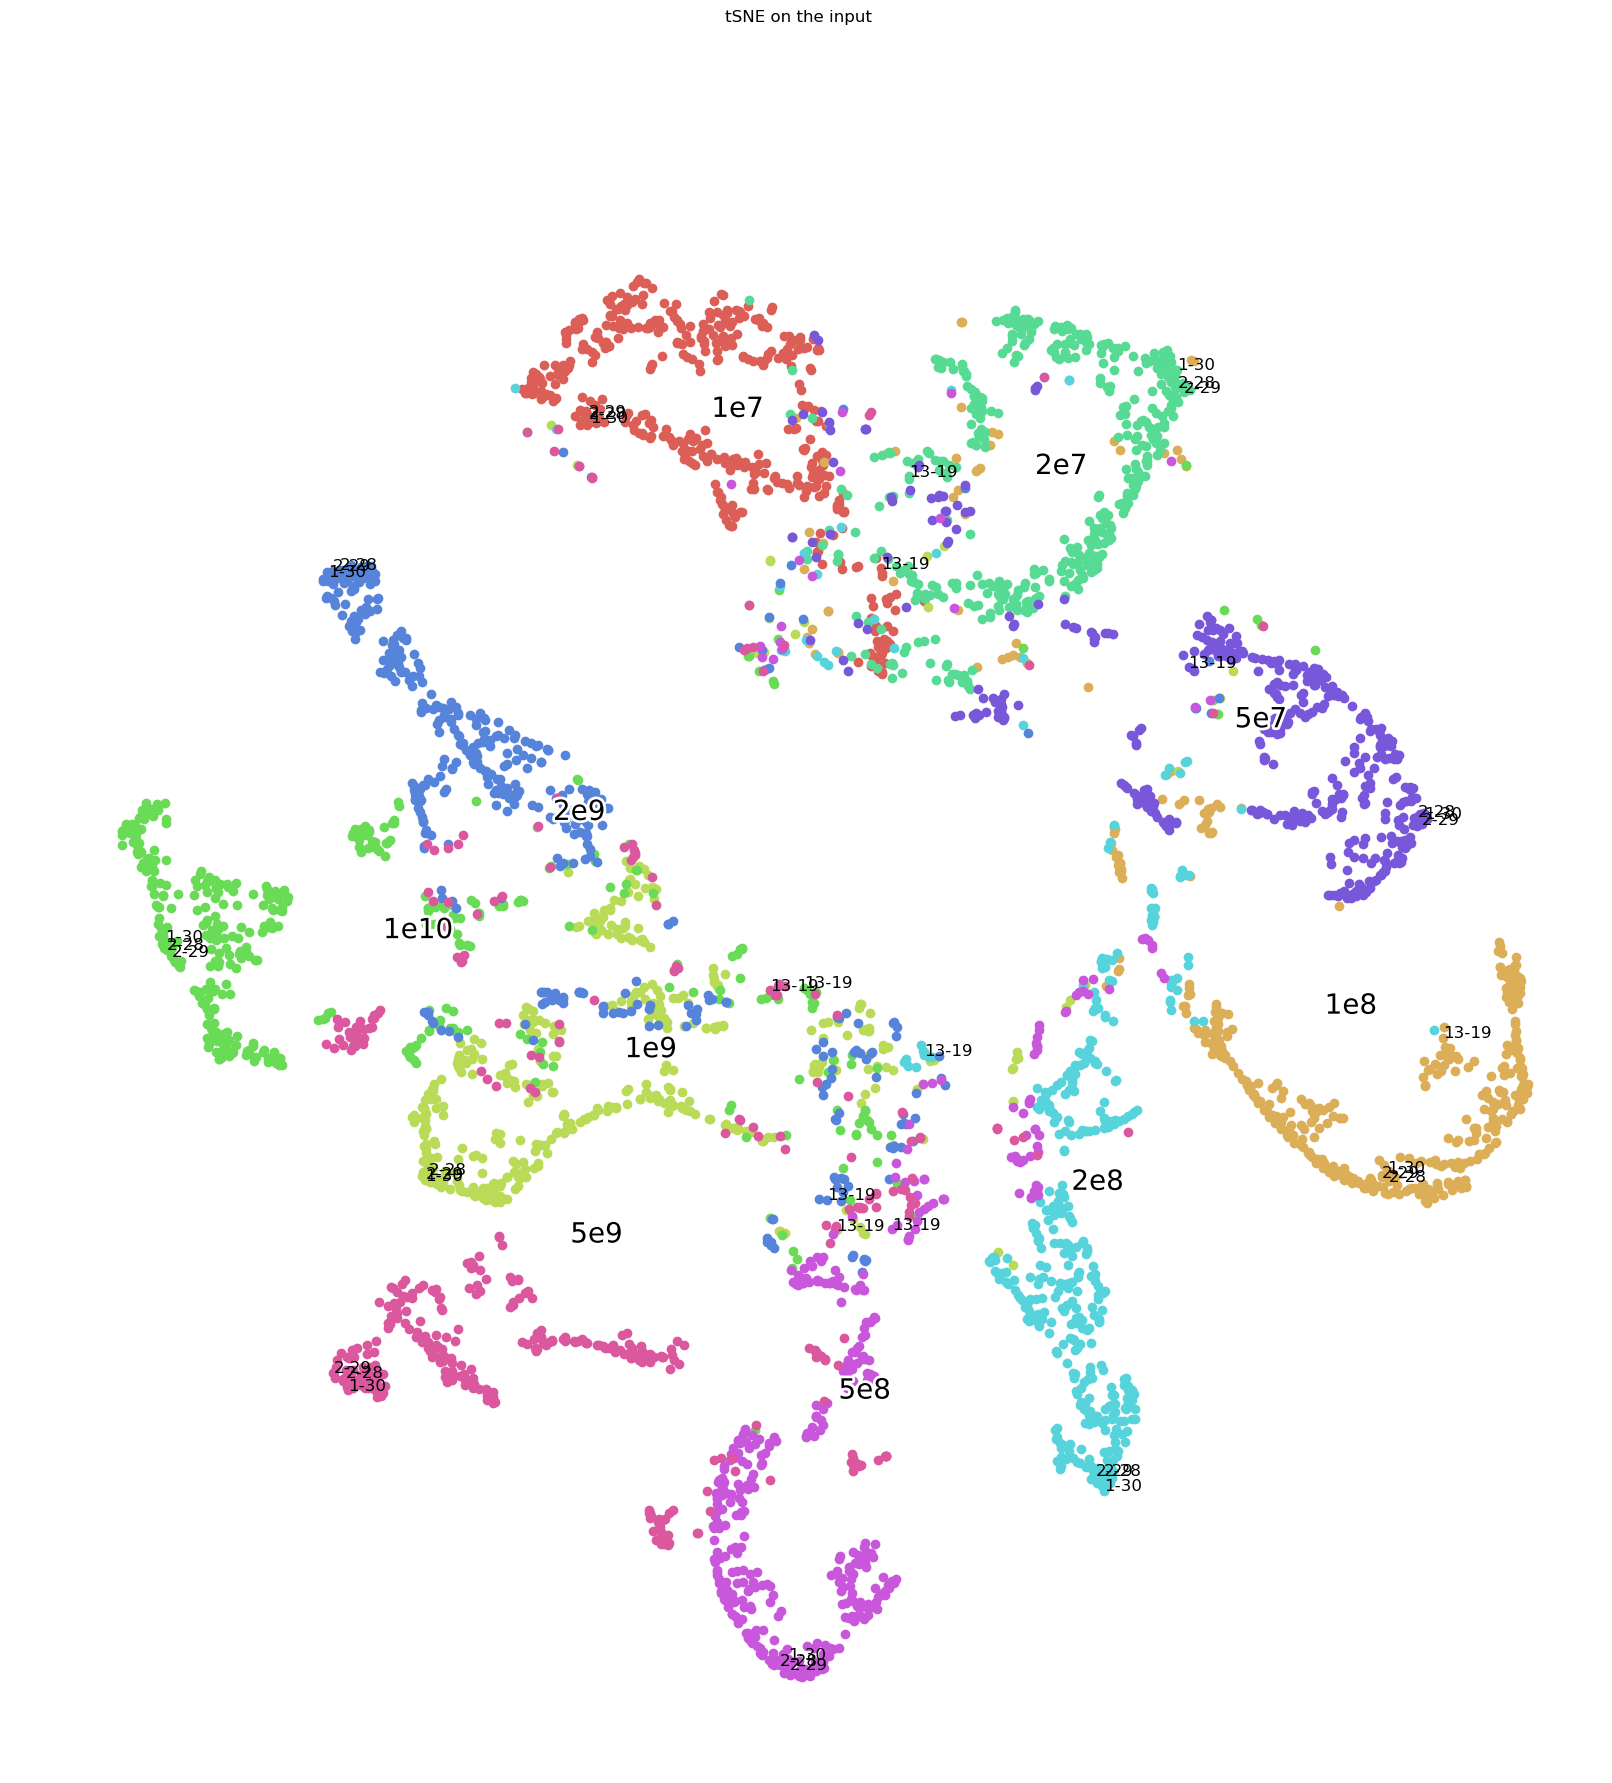

In [202]:
# initializing TSNE for 2 n_components.
#tsne = TSNE(n_components=2, random_state=0, perplexity=45, n_iter=2000)
tsne = TSNE(n_components=2, random_state=0)
tSNEResult = tsne.fit_transform(arr_transformed)

titleText = "tSNE on the input" 
scatterPlot(tSNEResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(0.563543,-0.065993,'1e7'),
  Text(0.340847,-0.0104664,'1e8'),
  Text(-0.379109,-0.0493113,'1e9'),
  Text(-0.510362,-0.225274,'1e10'),
  Text(0.53003,-0.0500222,'2e7'),
  Text(0.13313,0.0922636,'2e8'),
  Text(-0.476711,-0.0944763,'2e9'),
  Text(0.485194,-0.00999989,'5e7'),
  Text(-0.207025,0.33077,'5e8'),
  Text(-0.479539,0.0825103,'5e9')])

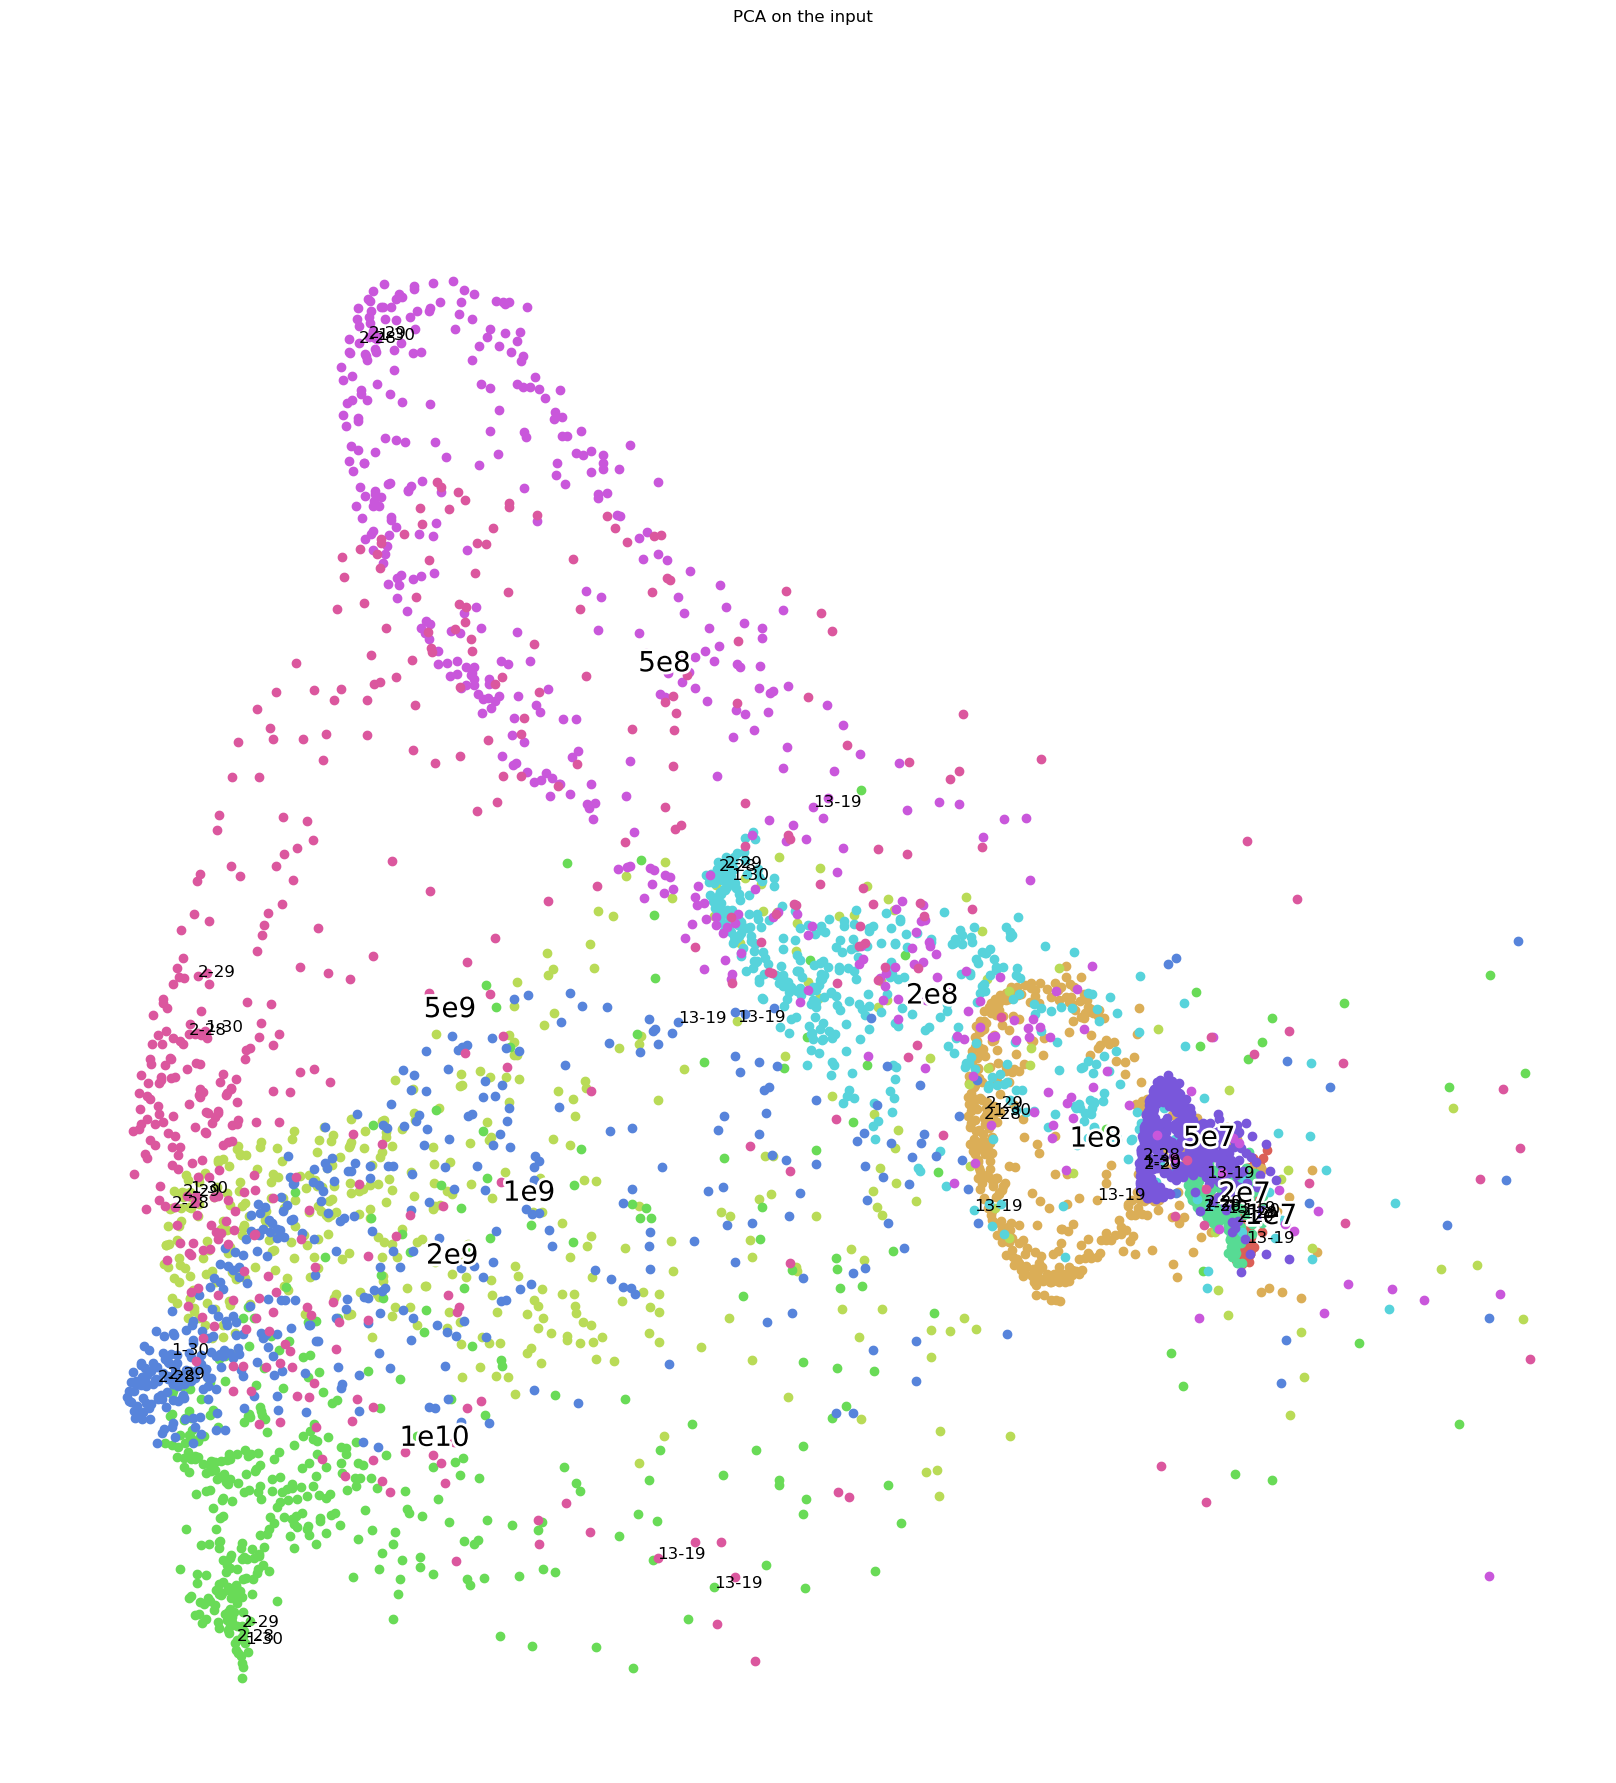

In [203]:
# initializing PCA for 2 n_components.
pca = PCA(n_components=2, random_state=0)
pcaResult = pca.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "PCA on the input"
scatterPlot(pcaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(0.017052,-0.00552834,'1e7'),
  Text(0.0102819,-0.000783282,'1e8'),
  Text(-0.0113707,-0.00442845,'1e9'),
  Text(-0.0151369,-0.0197767,'1e10'),
  Text(0.016025,-0.00415219,'2e7'),
  Text(0.00391259,0.00807156,'2e8'),
  Text(-0.0142633,-0.00839171,'2e9'),
  Text(0.014631,-0.00068904,'5e7'),
  Text(-0.00659315,0.0286825,'5e8'),
  Text(-0.0145384,0.00699571,'5e9')])

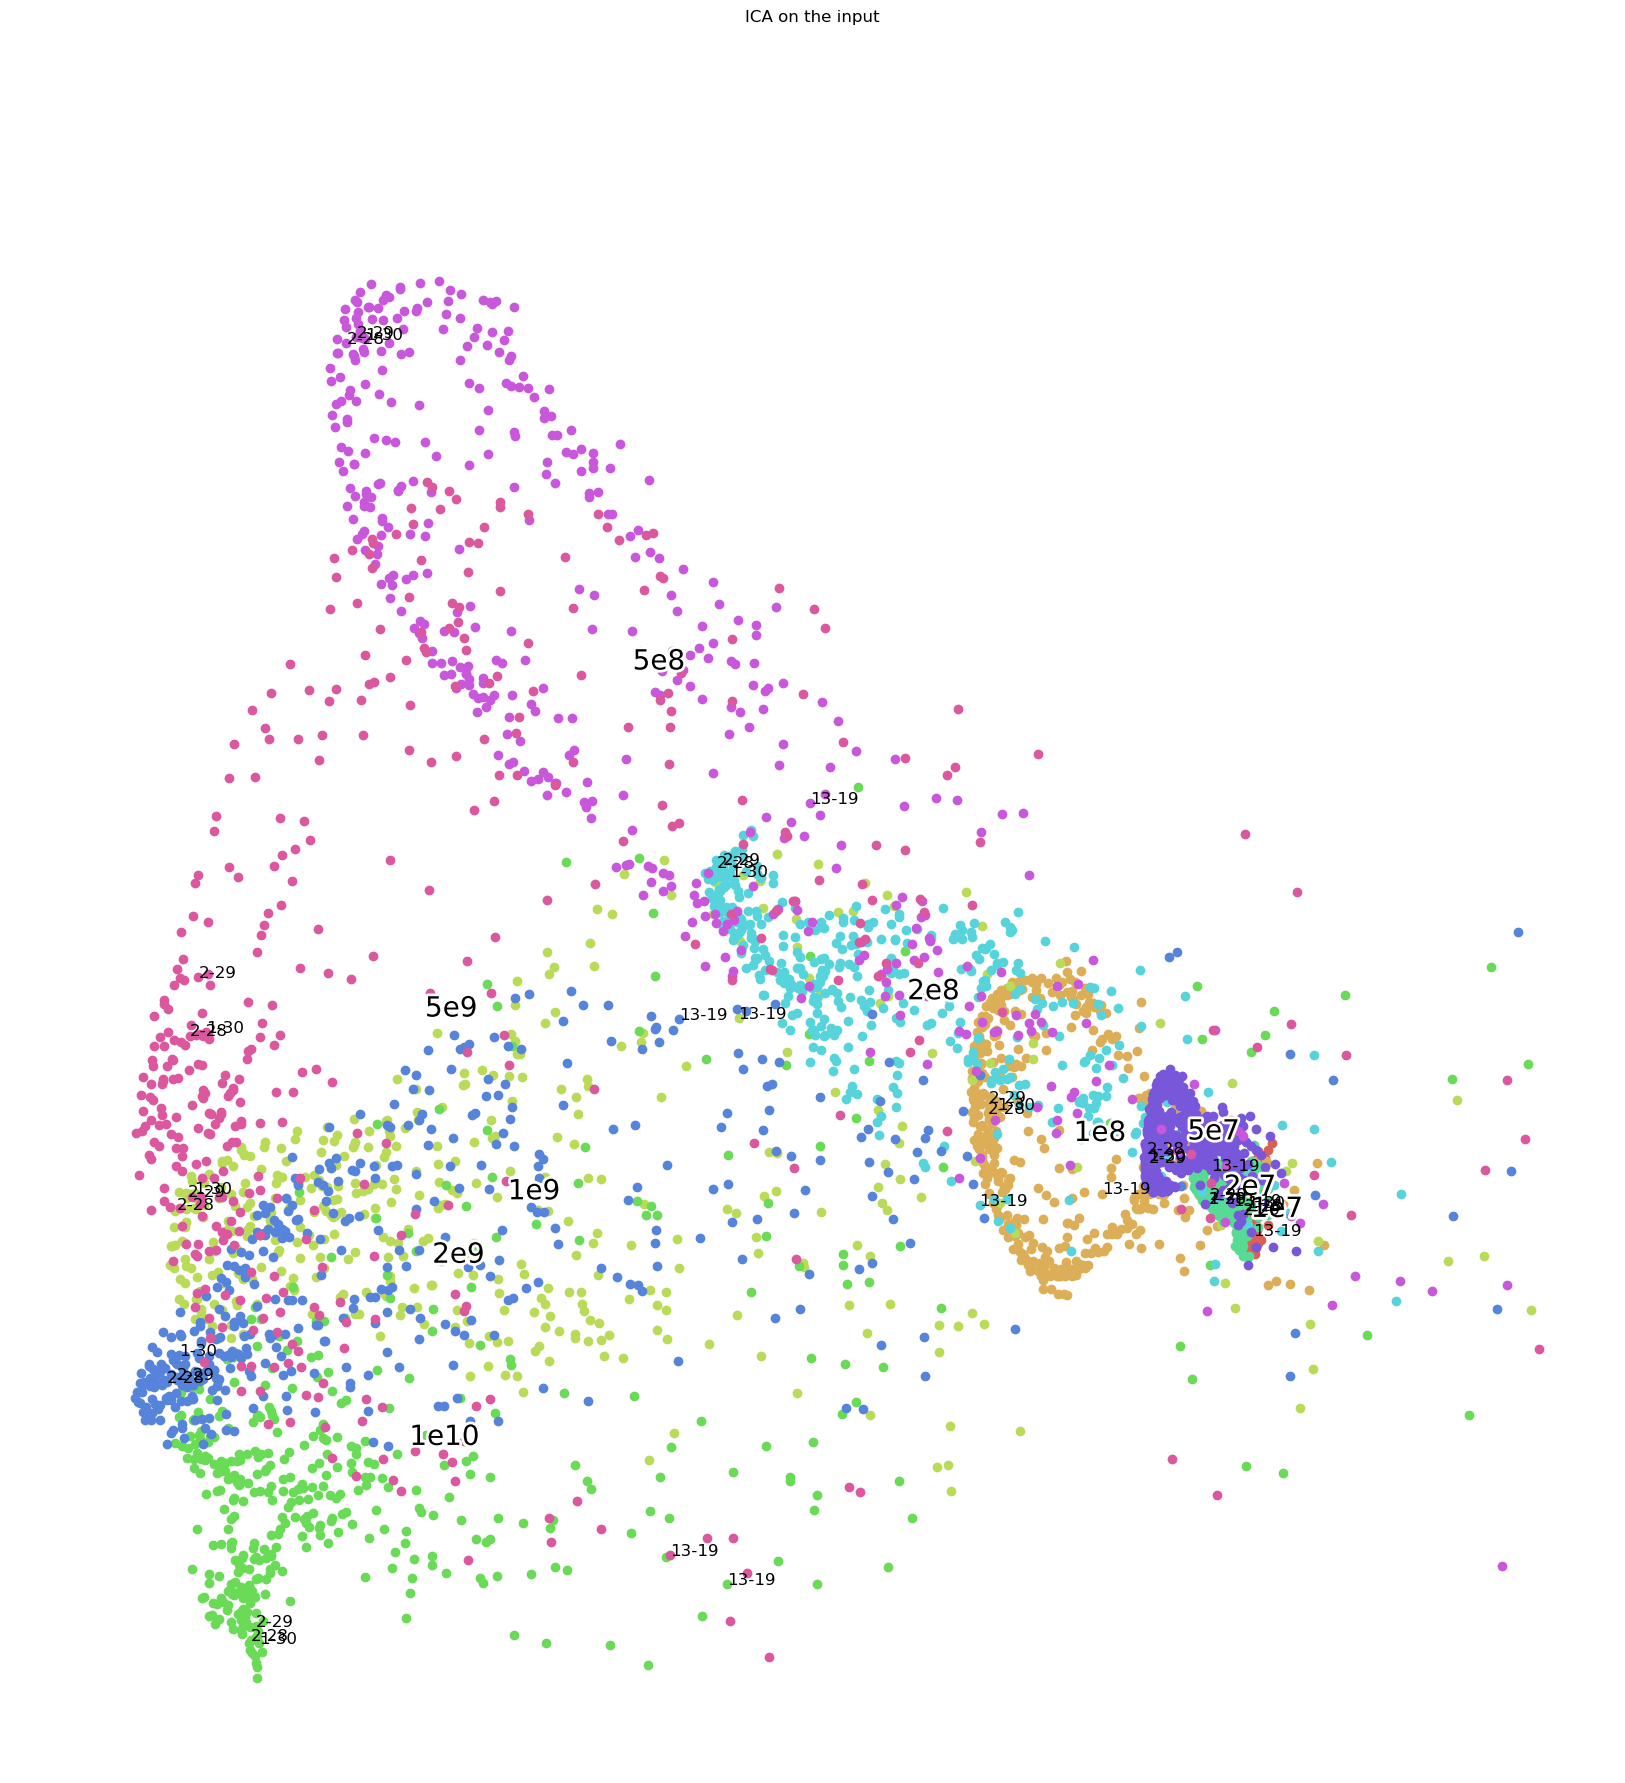

In [204]:
# initializing ICA for 2 n_components.
ICA = FastICA(n_components=2, random_state=0) 
icaResult=ICA.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "ICA on the input"
scatterPlot(icaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

### Clustering results on last 10 files

In [205]:
arr_controlled = average_from_time_series(arr_time_series=arr_time_series, data_limit = 200)

#print_eignvalues_for_a_pair(arr_controlled, ylabel_text, pair_choise = 28)

In [206]:
def get_order_parameter(input_data, ylabel_text, pair_choise = [28]):
    all_order_data= []
    for pair_ in pair_choise:
        test = input_data[[i+pair_ for i in range(0, input_data.shape[0], int(input_data.shape[0]/len(ylabel_text)))]]
        all_order_data.append(test)
    all_order_data = np.array(all_order_data)
    all_order_data = np.average(all_order_data, axis=0)
    print(all_order_data.shape)
    
    return all_order_data

def pretty_pair_labels(labels):
    return [str(int(labels[i][0])) + " - " + str(int(labels[i][1])) for i in range(labels.shape[0])]


In [108]:
#24  1 - 26
#25  1 - 27
#26  1 - 28
#27  1 - 29
#28  1 - 30
#53  2 - 27
#54  2 - 28
#55  2 - 29
#56  2 - 30
#82  3 - 29 
#83  3 - 30
#108 4 - 29  
#109 4 - 30 
pairlabel_selected[28]
pretty_pair_labels(pairlabel_selected[[28]])


['1 - 30']

(4, 6)


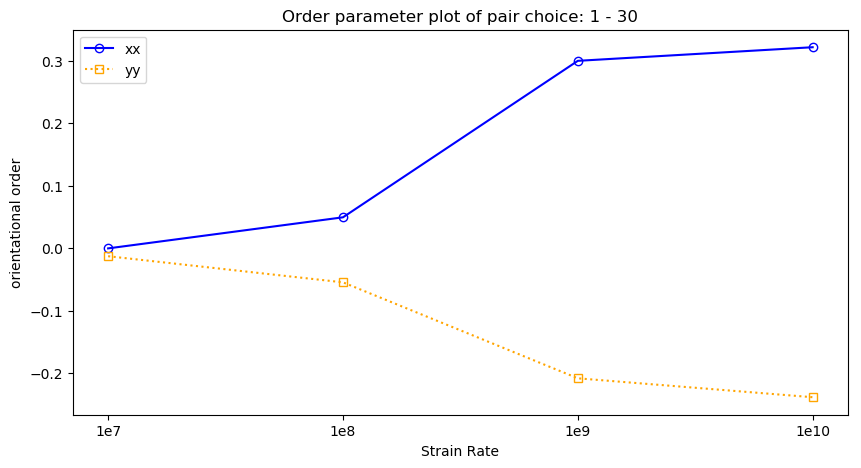

In [110]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

pair_choise = [28]

test = get_order_parameter(arr_selected, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





(4, 6)


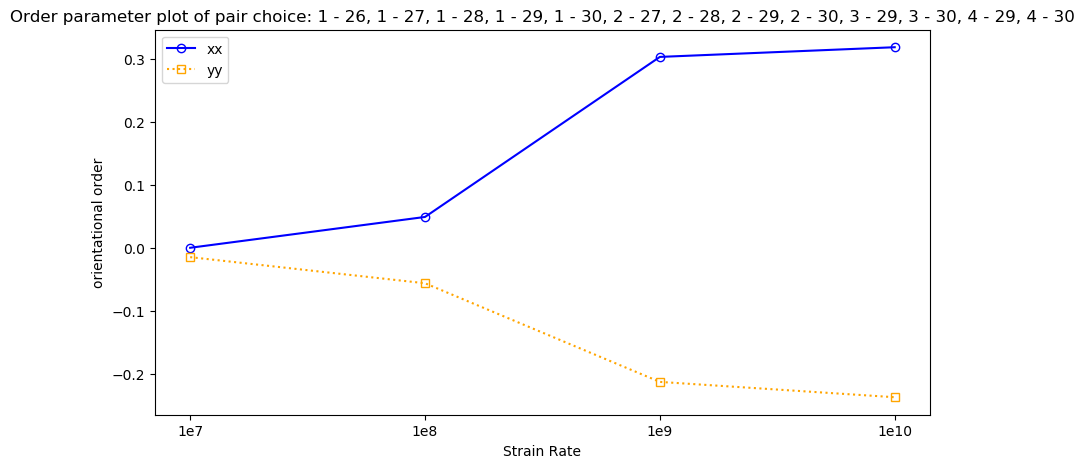

In [117]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#24  1 - 26
#25  1 - 27
#26  1 - 28
#27  1 - 29
#28  1 - 30
#53  2 - 27
#54  2 - 28
#55  2 - 29
#56  2 - 30
#82  3 - 29 
#83  3 - 30
#108 4 - 29  
#109 4 - 30 

pair_choise = [24,25,26,27,28, 53, 54, 55, 56 , 82, 83, 108, 109]
#pair_choise = [27, 28, 56]

test = get_order_parameter(arr_selected, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





In [135]:
# Here 2* SR is ignored as they are very near

datasize_pair=435
how_many=4

arr_selected = arr_controlled[0:datasize_pair*how_many, 1:]
ylabel_selected = ylabel[0:datasize_pair*how_many]
ylabel_text_selected = ylabel_text[0:how_many]
pairlabel_selected = pairlabel[0:datasize_pair*how_many]

sc = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#sc = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#sc = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#sc = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
arr_transformed = sc.fit_transform(arr_selected)
#arr_transformed = arr_selected
#arr_transformed = arr_selected

(4, 2)


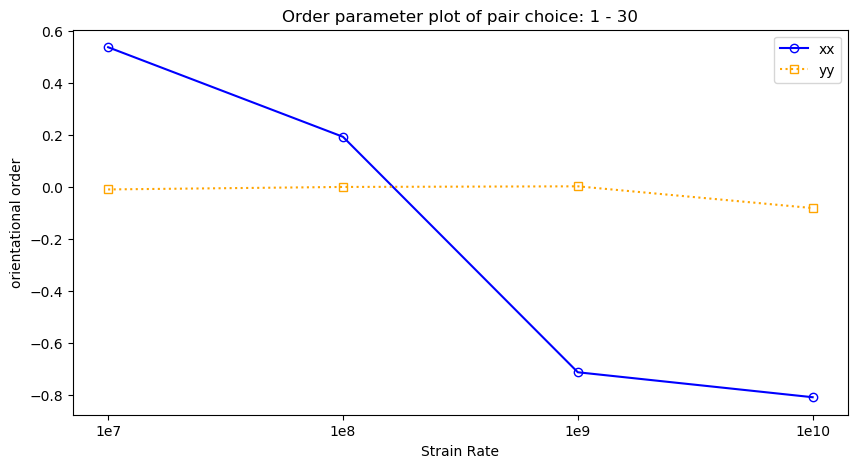

In [138]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#24  1 - 26
#25  1 - 27
#26  1 - 28
#27  1 - 29
#28  1 - 30
#53  2 - 27
#54  2 - 28
#55  2 - 29
#56  2 - 30
#82  3 - 29 
#83  3 - 30
#108 4 - 29  
#109 4 - 30 

#pair_choise = [24,25,26,27,28, 53, 54, 55, 56 , 82, 83, 108, 109]
pair_choise = [28]

test = get_order_parameter(pcaResult, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(-1.24855,59.3375,'1e7'),
  Text(43.8358,-13.5837,'1e8'),
  Text(-24.8536,-7.35101,'1e9'),
  Text(-46.5216,2.53953,'1e10'),
  Text(27.9488,43.4552,'2e7'),
  Text(18.9528,-27.184,'2e8'),
  Text(-26.1787,12.6149,'2e9'),
  Text(46.231,16.3711,'5e7'),
  Text(-8.24016,-45.6507,'5e8'),
  Text(-32.32,-27.1129,'5e9')])

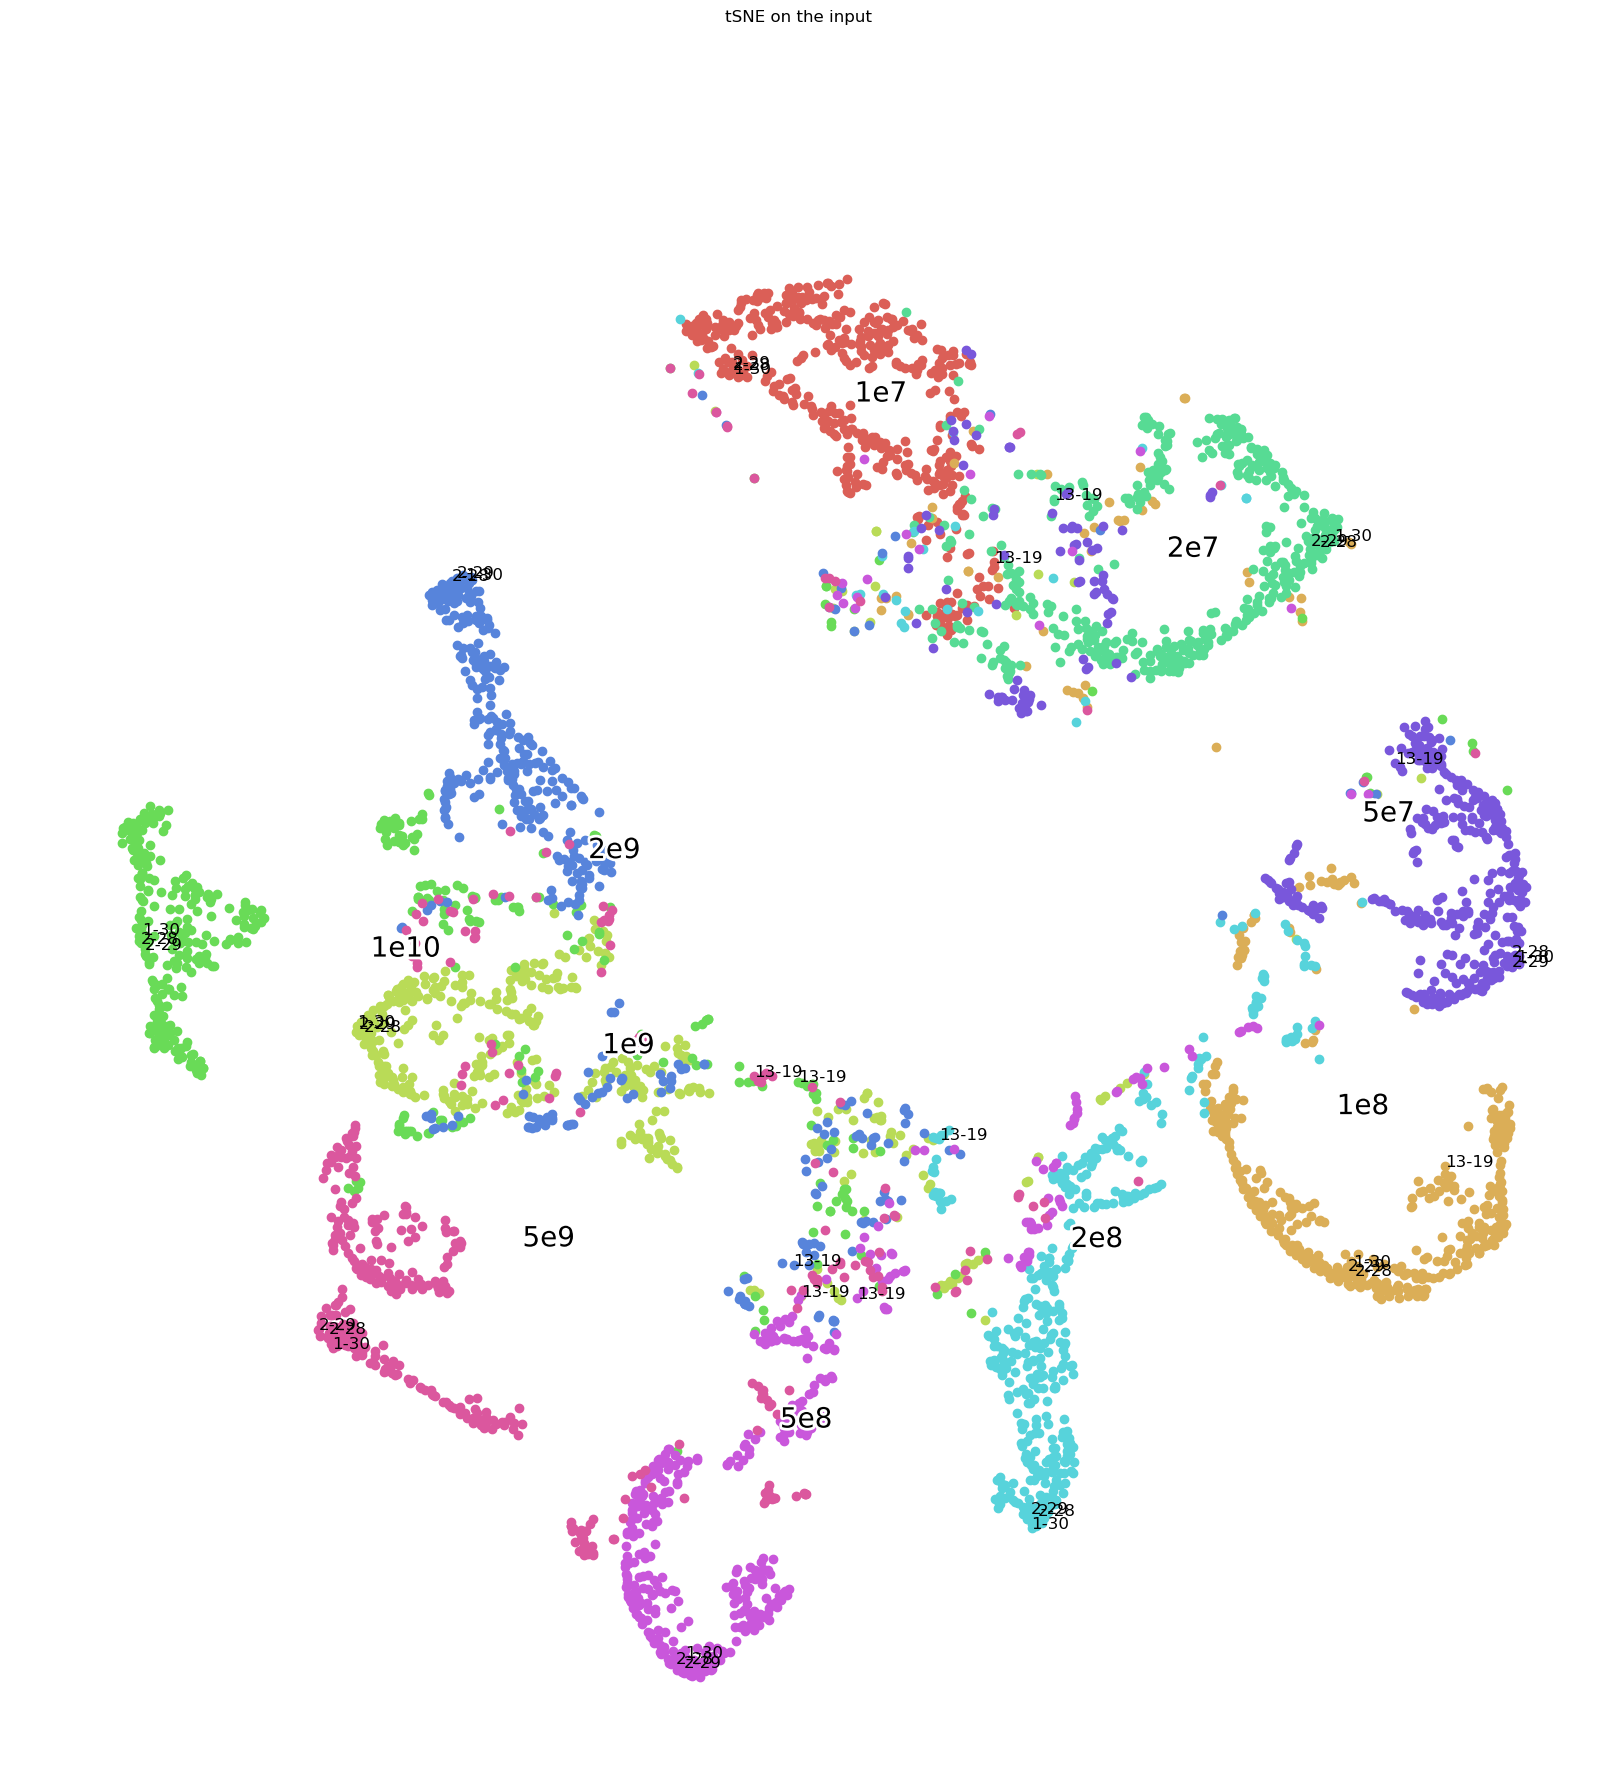

In [207]:
# initializing TSNE for 2 n_components.
tsne = TSNE(n_components=2, random_state=0, perplexity=45, n_iter=2000)
tSNEResult = tsne.fit_transform(arr_transformed)

titleText = "tSNE on the input" 
scatterPlot(tSNEResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

In [170]:
print(projected_data[0])
print(pcaResult[0])
print(projected_data2[0])
pca.explained_variance_

[0.01141309 0.00060226]
[ 0.25512004 -0.02381595]
[-0.07273396 -0.00557733]


array([0.0120097 , 0.00046258])

In [208]:
# initializing PCA for 2 n_components.
datasize_pair=435
how_many=3
how_many_end=4

arr_selected_pca = arr_controlled[datasize_pair*how_many:datasize_pair*how_many_end, 1:]

pca = PCA(n_components=2, random_state=0)
pcaResult = pca.fit_transform(arr_selected_pca)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

datasize_pair=435
how_many=4
projected_data = np.matmul(arr_controlled[0:datasize_pair*how_many, 1:], pca.components_.T)
projected_data2 = np.matmul(arr_selected_pca, pca.components_.T)

projected_data.shape
# Visualizing the PCA output
titleText = "PCA on the input"
scatterPlot(projected_data, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

[0.92688993 0.03954866]
[2.22395687 0.45938645]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1740 but corresponding boolean dimension is 4350

<Figure size 2000x2000 with 0 Axes>

In [ ]:
# initializing PCA for 2 n_components.


datasize_pair=435
how_many=3
how_many_end=4

arr_selected_pca = arr_controlled[datasize_pair*how_many:datasize_pair*how_many_end, 1:]


pca = PCA(n_components=2, random_state=0)
pcaResult = pca.fit_transform(arr_selected_pca)

datasize_pair=435
how_many=4
projected_data = np.matmul(arr_controlled[0:datasize_pair*how_many, 1:2], pca.components_.T[0:1])

projected_data.shape
# Visualizing the PCA output
titleText = "PCA on the input"
scatterPlot(projected_data, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

In [ ]:
# initializing PCA for 2 n_components.
pca = PCA(n_components=2, random_state=0)
pcaResult = pca.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "PCA on the input"
scatterPlot(pcaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

In [ ]:
# initializing ICA for 2 n_components.
ICA = FastICA(n_components=2, random_state=0) 
icaResult=ICA.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "ICA on the input"
scatterPlot(icaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)